# Overlaid Histograms

Combine the background data with the simulated data to get a better understanding of their relation

# Imports

In [6]:
import uproot4
import uproot
import awkward1 as ak
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
import os,sys
import pandas as pd
from scipy.stats import halfnorm
from coffea import hist

# file I/O

In [3]:
ls ..

2017_data_analysis.ipynb  combined_data/
80-87/                    data/
80-87_Analysis.ipynb      overlay_histograms/
DC_IDs.JPG*               tracklets_2017_hodoscopes.ipynb
HodoscopeDimensions.png*  tracklets_2017_initial/
combined.root


using relative paths from this directory

In [4]:
# background data
BG = uproot4.concatenate("../combined_data/track_*.root:save/rawEvent",["fTriggerBits","fAllHits.pos","fAllHits.driftDistance","fAllHits.detectorID"],library="ak",how="zip")

In [8]:
# sim data

Brem003 = "../../electrons/sim_eval_Brem_0.033428_z500_600_eps_-5.2.root"
truth003 = uproot.open(Brem003)["Truth"]

Brem047 = "../../electrons/sim_eval_Brem_0.470915_z500_600_eps_-6.root"
truth047 = uproot.open(Brem047)["Truth"]

Eta001 = "../../electrons/sim_eval_Eta_0.019564_z500_600_eps_-5.2.root"
truth001 = uproot.open(Eta001)["Truth"]

Eta054 = "../../electrons/sim_eval_Eta_0.540000_z500_600_eps_-6.root"
truth054 = uproot.open(Eta054)["Truth"]

# Getting 2017 data

Here we grab the data from the 2017 files. We will do the same for the background data, and then have a plotting function which overlays the two

In [10]:
# select detector
def detectorRange(arr, detid1, detid2):
    mask = (arr.detectorID >= detid1)
    mask = mask & (arr.detectorID <= detid2) 
    return mask

def detectorSelection(arr, detid):
    mask = (arr.detectorID== detid)
    return mask

# build detector mask
def detectorMask(arr):
    detmask = {}
    for key,item in detID_dict.items():
        for keyd,det in item['det'].items():
            if len(det)==1:
                detmask[keyd] = detectorSelection(arr,det[0])
            else:
                detmask[keyd] = detectorRange(arr,det[0],det[1])
    return detmask

detID_dict = {'BT':{'dir':'x',
                    'det':{'H1BT':[31,32],
                           'H2BT':[37,38],
                           #'H3BT':[39,40],
                           'H4BT':[45,46]
                          }
                    },
              'LR':{'dir':'y',
                    'det':{'H1LR':[33,34],
                           'H2LR':[35,36],
                           'H4Y1LR':[41,42],
                           'H4Y2LR':[43,44]
                          }
                   }
             }

In [81]:
def get_data_2017(root):
    '''
    returns a list of histogram information
    '''
    # mask w. triggerBits &(32|128) - Random trigger
    trigmask = (root.fTriggerBits == 67)
    trigmask = trigmask | (root.fTriggerBits == 65)
    
    # get and mask all hits
    allhits = root.fAllHits
    maskedhits = ak.mask(allhits,trigmask)
    detmask = detectorMask(allhits)
    
    # hit/event rate acquired by dividing by nevents
    nevents = len(ak.flatten(ak.count(maskedhits.pos,axis=-1),0))
    
    # store hists
    xs = []
    
    for dets,item in detID_dict.items():
        direction = item['dir']
        detectors = item['det']
        for det in detectors.keys():
            maskedhits_det = maskedhits[detmask[det]]
            numpos = ak.num(maskedhits_det.pos)
            
            xs.append(ak.flatten(maskedhits_det.pos))   # these will be plotted
            
    return xs, nevents

# Getting sim data

In [79]:
'''
def get_data_sim(root1, root2, name1, name2):
    '''
    gets histograms for sim data
    '''
    (root1.array("hit_detID").flatten() >= 1).any()
    masks1 = {}
    (root2.array("hit_detID").flatten() >= 1).any()
    masks2 = {}
    
    # mask by hit detID
    detID1 = root1.array("hit_detID").flatten()
    detID2 = root2.array("hit_detID").flatten()
    
    # mask by z pos of detector
    truthz1 = root1.array("hit_truthz").flatten()
    truthz2 = root2.array("hit_truthz").flatten()
    
    # hodos
    masks1["h1BT"] = np.logical_and(detID1 >= 31, detID1 <= 32)
    masks2["h1BT"] = np.logical_and(detID2 >= 31, detID2 <= 32)
    masks1["h2BT"] = np.logical_and(detID1 >= 37, detID1 <= 38)
    masks2["h2BT"] = np.logical_and(detID2 >= 37, detID2 <= 38)
    masks1["h4BT"] = np.logical_and(detID1 >= 45, detID1 <= 46)
    masks2["h4BT"] = np.logical_and(detID2 >= 45, detID2 <= 46)
    masks1["h1LR"] = np.logical_and(detID1 >= 33, detID1 <= 34)
    masks2["h1LR"] = np.logical_and(detID2 >= 33, detID2 <= 34)
    masks1["h2LR"] = np.logical_and(detID1 >= 35, detID1 <= 36)
    masks2["h2LR"] = np.logical_and(detID2 >= 35, detID2 <= 36)
    masks1["h4Y1LR"] = np.logical_and(detID1 >= 41, detID1 <= 42)
    masks2["h4Y1LR"] = np.logical_and(detID2 >= 41, detID2 <= 42)
    masks1["h4Y2LR"] = np.logical_and(detID1 >= 43, detID1 <= 44)
    masks2["h4Y2LR"] = np.logical_and(detID2 >= 43, detID2 <= 44)

    
    '''
    masks1["h1BT"] = np.logical_and(detID1 >= 31, detID1 <= 32)
    masks2["h1BT"] = np.logical_and(detID2 >= 31, detID2 <= 32)
    masks1["h1LR"] = np.logical_and(detID1 >= 33, detID1 <= 34)
    masks2["h1LR"] = np.logical_and(detID2 >= 33, detID2 <= 34)
    masks1["h2LR"] = np.logical_and(detID1 >= 35, detID1 <= 36)
    masks2["h2LR"] = np.logical_and(detID2 >= 35, detID2 <= 36)
    masks1["h2BT"] = np.logical_and(detID1 >= 37, detID1 <= 38)
    masks2["h2BT"] = np.logical_and(detID2 >= 37, detID2 <= 38)
    masks1["h4Y1LR"] = np.logical_and(detID1 >= 41, detID1 <= 42)
    masks2["h4Y1LR"] = np.logical_and(detID2 >= 41, detID2 <= 42)
    masks1["h4Y2LR"] = np.logical_and(detID1 >= 43, detID1 <= 44)
    masks2["h4Y2LR"] = np.logical_and(detID2 >= 43, detID2 <= 44)
    masks1["h4BT"] = np.logical_and(detID1 >= 45, detID1 <= 46)
    masks2["h4BT"] = np.logical_and(detID2 >= 45, detID2 <= 46)
    '''
    
    # stations
    masks1["st1"] = np.logical_and(truthz1 > 500, truthz1 < 1000)
    masks2["st1"] = np.logical_and(truthz2 > 500, truthz2 < 1000)
    masks1["st2"] = np.logical_and(truthz1 > 1200, truthz1 < 1600)
    masks2["st2"] = np.logical_and(truthz2 > 1200, truthz2 < 1600)
    masks1["st4"] = truthz1 > 2000
    masks2["st4"] = truthz2 > 2000 
    
    # det pairs
    det_st = [('h1BT', 'st1'),
              ('h2BT', 'st1'),
              ('h4BT', 'st2'),
              ('h1LR', 'st2'),
              ('h2LR', 'st4'),
              ('h4Y1LR', 'st4'),
              ('h4Y2LR', 'st4')]
    
    # geometry, can safely ignore z pos for now
    vs = [("xy","hit_truthy:hit_truthx","x [cm];y [cm]"),
          ("z","hit_truthz","z [cm]"),]
    
    # hit/event rate acquired by dividing by nevents
    nevents = len(ak.flatten(ak.count(maskedhits.pos,axis=-1),0))
    
    xs = []
    
    for det, st in det_st:
        for vshort, var, vtitle in vs:
            mask1 = np.logical_and(masks1[det],masks1[st])
            mask2 = np.logical_and(masks2[det],masks2[st])
            ivars1 = [root1.array(v).flatten() for v in var.split(":")]
            ivars2 = [root2.array(v).flatten() for v in var.split(":")]
            ilabs = vtitle.split(';')
            
            if (len(ivars1)>1) and (len(ivars2)>1):
                # stacking the data
                if (det[-1]=='T'):
                    x = [ivars1[0][mask1], ivars2[0][mask2]]
                else:
                    x = [ivars1[1][mask1], ivars2[1][mask2]]
                    
                xs.append(x)
    return xs, nevents
'''

IndentationError: unexpected indent (<ipython-input-79-44589928baf7>, line 4)

**This one works, use this**

In [80]:
def get_data_sim(root1, root2, name1, name2):
    
    (root1.array("hit_detID").flatten() >= 1).any()
    masks1 = {}
    (root2.array("hit_detID").flatten() >= 1).any()
    masks2 = {}
    
    # mask by hit detID
    detID1 = root1.array("hit_detID").flatten()
    detID2 = root2.array("hit_detID").flatten()
    
    # mask by z pos of detector
    truthz1 = root1.array("hit_truthz").flatten()
    truthz2 = root2.array("hit_truthz").flatten()
    
    # hodos
    masks1["h1BT"] = np.logical_and(detID1 >= 31, detID1 <= 32)
    masks2["h1BT"] = np.logical_and(detID2 >= 31, detID2 <= 32)
    masks1["h1LR"] = np.logical_and(detID1 >= 33, detID1 <= 34)
    masks2["h1LR"] = np.logical_and(detID2 >= 33, detID2 <= 34)
    masks1["h2LR"] = np.logical_and(detID1 >= 35, detID1 <= 36)
    masks2["h2LR"] = np.logical_and(detID2 >= 35, detID2 <= 36)
    masks1["h2BT"] = np.logical_and(detID1 >= 37, detID1 <= 38)
    masks2["h2BT"] = np.logical_and(detID2 >= 37, detID2 <= 38)
    masks1["h4Y1LR"] = np.logical_and(detID1 >= 41, detID1 <= 42)
    masks2["h4Y1LR"] = np.logical_and(detID2 >= 41, detID2 <= 42)
    masks1["h4Y2LR"] = np.logical_and(detID1 >= 43, detID1 <= 44)
    masks2["h4Y2LR"] = np.logical_and(detID2 >= 43, detID2 <= 44)
    masks1["h4BT"] = np.logical_and(detID1 >= 45, detID1 <= 46)
    masks2["h4BT"] = np.logical_and(detID2 >= 45, detID2 <= 46)
    
    # stations
    masks1["st1"] = np.logical_and(truthz1 > 500, truthz1 < 1000)
    masks2["st1"] = np.logical_and(truthz2 > 500, truthz2 < 1000)
    masks1["st2"] = np.logical_and(truthz1 > 1200, truthz1 < 1600)
    masks2["st2"] = np.logical_and(truthz2 > 1200, truthz2 < 1600)
    masks1["st4"] = truthz1 > 2000
    masks2["st4"] = truthz2 > 2000 
    
    # det pairs (common for both Brem/Eta and between both masses)
    # TODO - work on EMCAL (st3) and showers
    det_st = [('h1BT', 'st1'),
              ('h1LR', 'st1'),
              ('h2LR', 'st2'),
              ('h2BT', 'st2'),
              ('h4Y1LR', 'st4'),
              ('h4Y2LR', 'st4'),
              ('h4BT', 'st4')]
    
    # geometry, can safely ignore z pos for now
    vs = [("xy","hit_truthy:hit_truthx","x [cm];y [cm]"),
          ("z","hit_truthz","z [cm]"),]
    
    xs = []
    
    # now implement all the masks, plotting each of the variables in det_pairs
    for det, st in det_st:
        for vshort, var, vtitle in vs:
            mask1 = np.logical_and(masks1[det],masks1[st])
            mask2 = np.logical_and(masks2[det],masks2[st])
            
            ivars1 = [root1.array(v).flatten() for v in var.split(":")]
            ivars2 = [root2.array(v).flatten() for v in var.split(":")]
            ilabs = vtitle.split(';')

            if (len(ivars1)>1) and (len(ivars2)>1):
                # stacking the data
                if (det[-1]=='T'):
                    x = [ivars1[0][mask1], ivars2[0][mask2]]
                else:
                    x = [ivars1[1][mask1], ivars2[1][mask2]]
                    
                xs.append(x)
                
    return xs


In [56]:
ys = get_data_sim(truth001,truth054,Eta001,Eta054)

In [57]:
ys[1]

[array([ 12.26848 ,  11.841511,  11.715292, ...,  44.071167, -35.241898,
        -28.764877], dtype=float32),
 array([-3.6724205, -3.6724205, -1.9182703, ...,  6.4260573, -2.299727 ,
        -9.843    ], dtype=float32)]

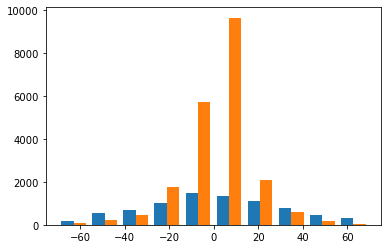

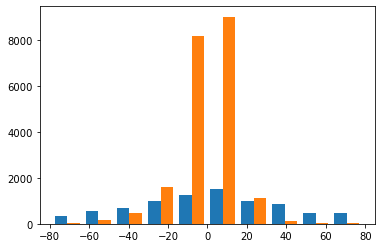

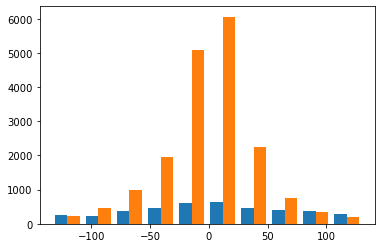

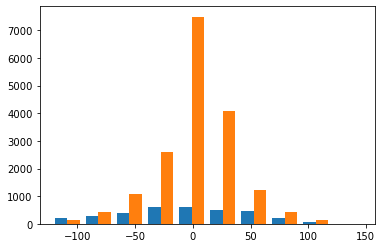

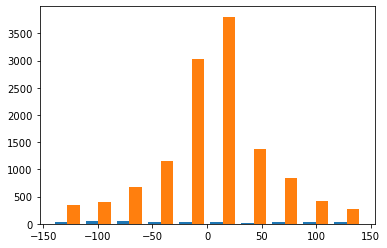

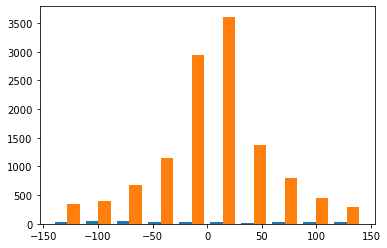

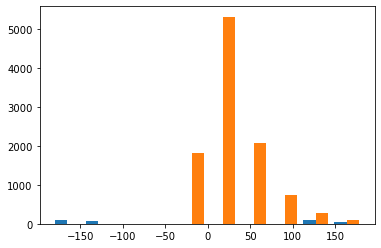

In [58]:
for i in range(len(ys)):
    plt.clf()
    plt.hist(ys[i])
    plt.show()

In [29]:
xs = get_data_2017(BG)

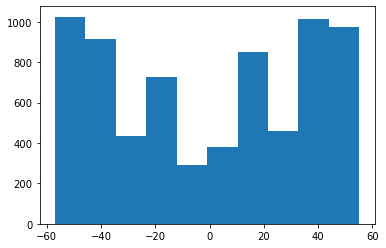

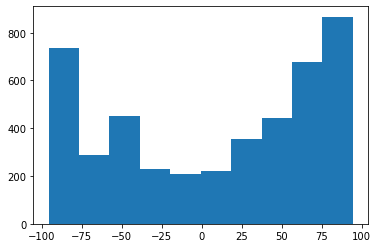

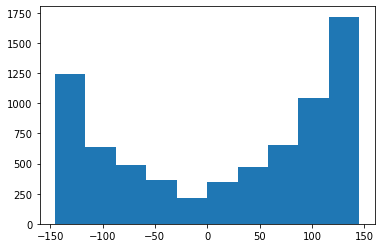

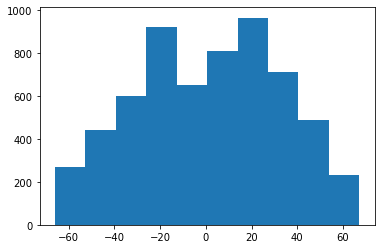

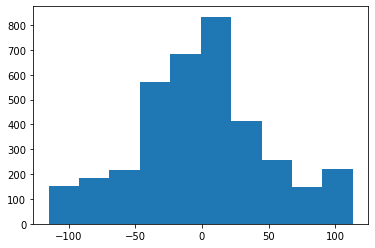

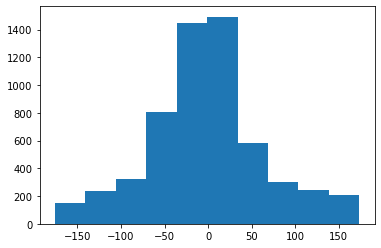

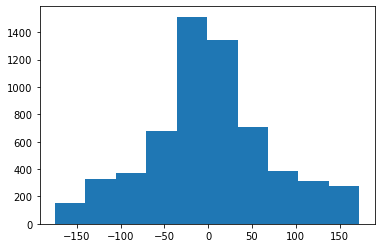

In [30]:
for i in range(len(xs)):
    plt.clf()
    plt.hist(xs[i])
    plt.show()

# next

At this point, we have two functions which can generate the histograms

* `get_data_2017` gives a list in the order:
    * h1bt
    * h2bt
    * h4bt
    * h1lr
    * h2lr
    * h4y1lr
    * h4y2lr
* whereas the order given by `get_data_sim` is in the order:
    * h1bt
    * h1lr
    * h2lr 
    * h2bt
    * h4y1lr
    * h4y2lr
    * h4bt
    
This necessitates a function which can plot from each list like so:

* 2017[0] & sim[0]
* 2017[1] & sim[3]
* 2017[2] & sim[6]
* 2017[3] & sim[1]
* 2017[4] & sim[2]
* 2017[5] & sim[4]
* 2017[6] & sim[5]

There will be constant binning list, where the indexing must be done in the same order as above

As well, have to figure out some way to label the masses. the masses will be based on the order in which they are entered into the function

In [108]:
def combine_histogram(root_2017, root1, root2, name1, name2):
    '''
    root_2017 - 2017 file
    root1, root2 = sim files
    name1, name2 = sim file names
    '''
    # sim info
    process = name1.split("_")[2]
    mass1 = name1.split("_")[3]
    mass2 = name2.split("_")[3]
    masses = [mass1,mass2]
    
    # constant for all data 
    bins_range = [(46, (-162.008,162.008), "H1BT"),
                  (32, (-203.38,203.38), "H2BT"),
                  (32, (-304.518,304.518), "H4BT"),
                  (40, (-140.117,140.117), "H1LR"),
                  (38, (-241.285,241.285), "H2LR"),
                  (32, (-365.797,365.797), "H4Y1LR"),
                  (32, (-365.797,365.797), "H4Y2LR")]
    
    # get lists w histogram info
    data_2017, nevents2017 =  get_data_2017(root_2017)
    data_sim = get_data_sim(root1, root2, name1, name2)
    
    # since the sim data is not in the same order, this is used to keep track
    # and ensure that the 2017 and sim data are showing the same hodoscope
    sim_order = [0,3,6,1,2,4,5]
    
    # plot
    for i in range(len(bins_range)):
        savename = "{}_{}_2017_sim_hitsPerEvent".format(bins_range[i][2],process)
        title = "Hits/Event in {} ({})".format(bins_range[i][2], process)
        plt.clf()   # clear the previous plot
        fig = plt.figure(dpi=300)
        
        '''plot 2017 data'''
        # weights
        ws2017 = np.ones_like(ak.to_numpy(data_2017[i]))/nevents2017
        if (i==2) or (i==5) or (i==6):
            # divide by 2, since st4 hodos count 2 hits for every one actual hit
            ws2017 /= 2
        
        # plot
        plt.hist(data_2017[i],bins=bins_range[i][0],range=bins_range[i][1],histtype='step',weights=ws2017,label='2017 data')
        
        '''plot sim data'''
        # weights -> need to be careful about index (sim out of order compared to 2017)
        nevents_sim = 10000
        wsSim = np.array([np.ones_like(data_sim[sim_order[i]][0]),np.ones_like(data_sim[sim_order[i]][1])])/nevents_sim
        # plot
        plt.hist(data_sim[sim_order[i]],bins=bins_range[sim_order[i]][0],range=bins_range[sim_order[i]][1],histtype='step',weights=wsSim,label=masses)
        
        # labeling plot
        plt.ylabel("Hits/Event")
        if (i<4):
            plt.xlabel("x [cm]")
        else:
            plt.xlabel("y [cm]")
        plt.title(title)
        plt.legend(prop={'size':10})
        plt.savefig(savename)
        plt.show()


<Figure size 432x288 with 0 Axes>

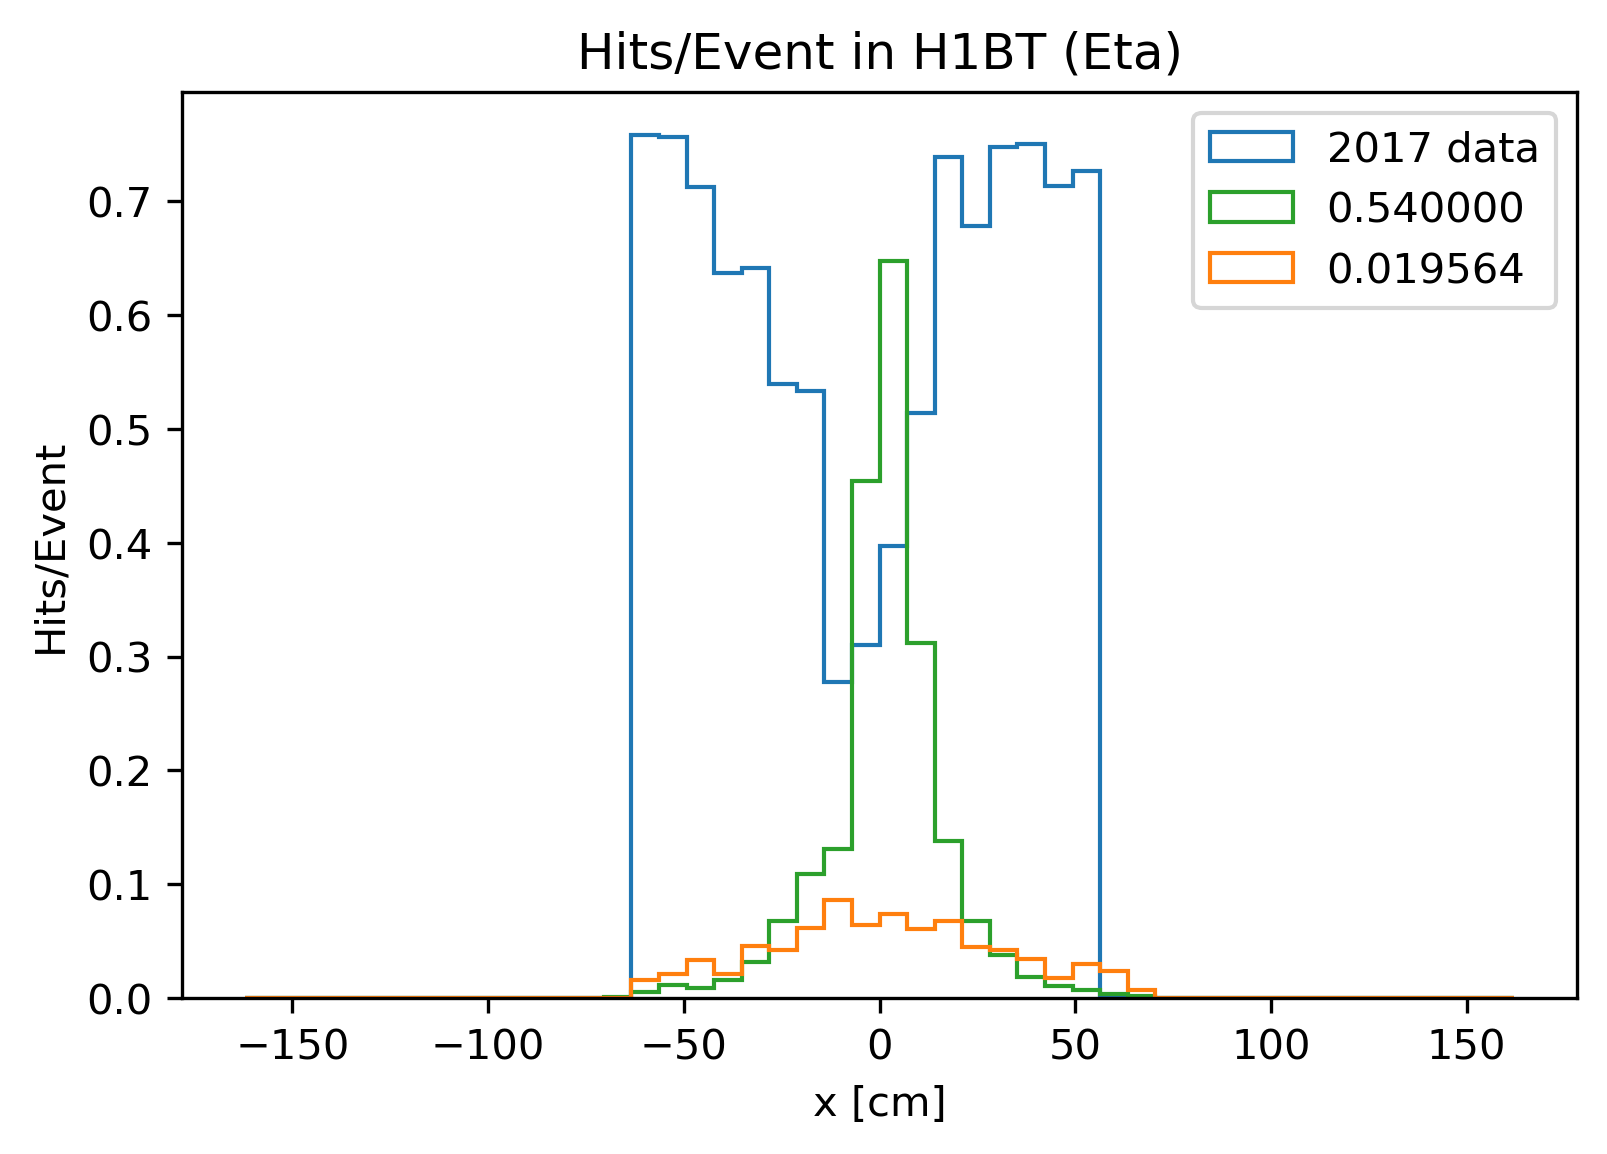

<Figure size 432x288 with 0 Axes>

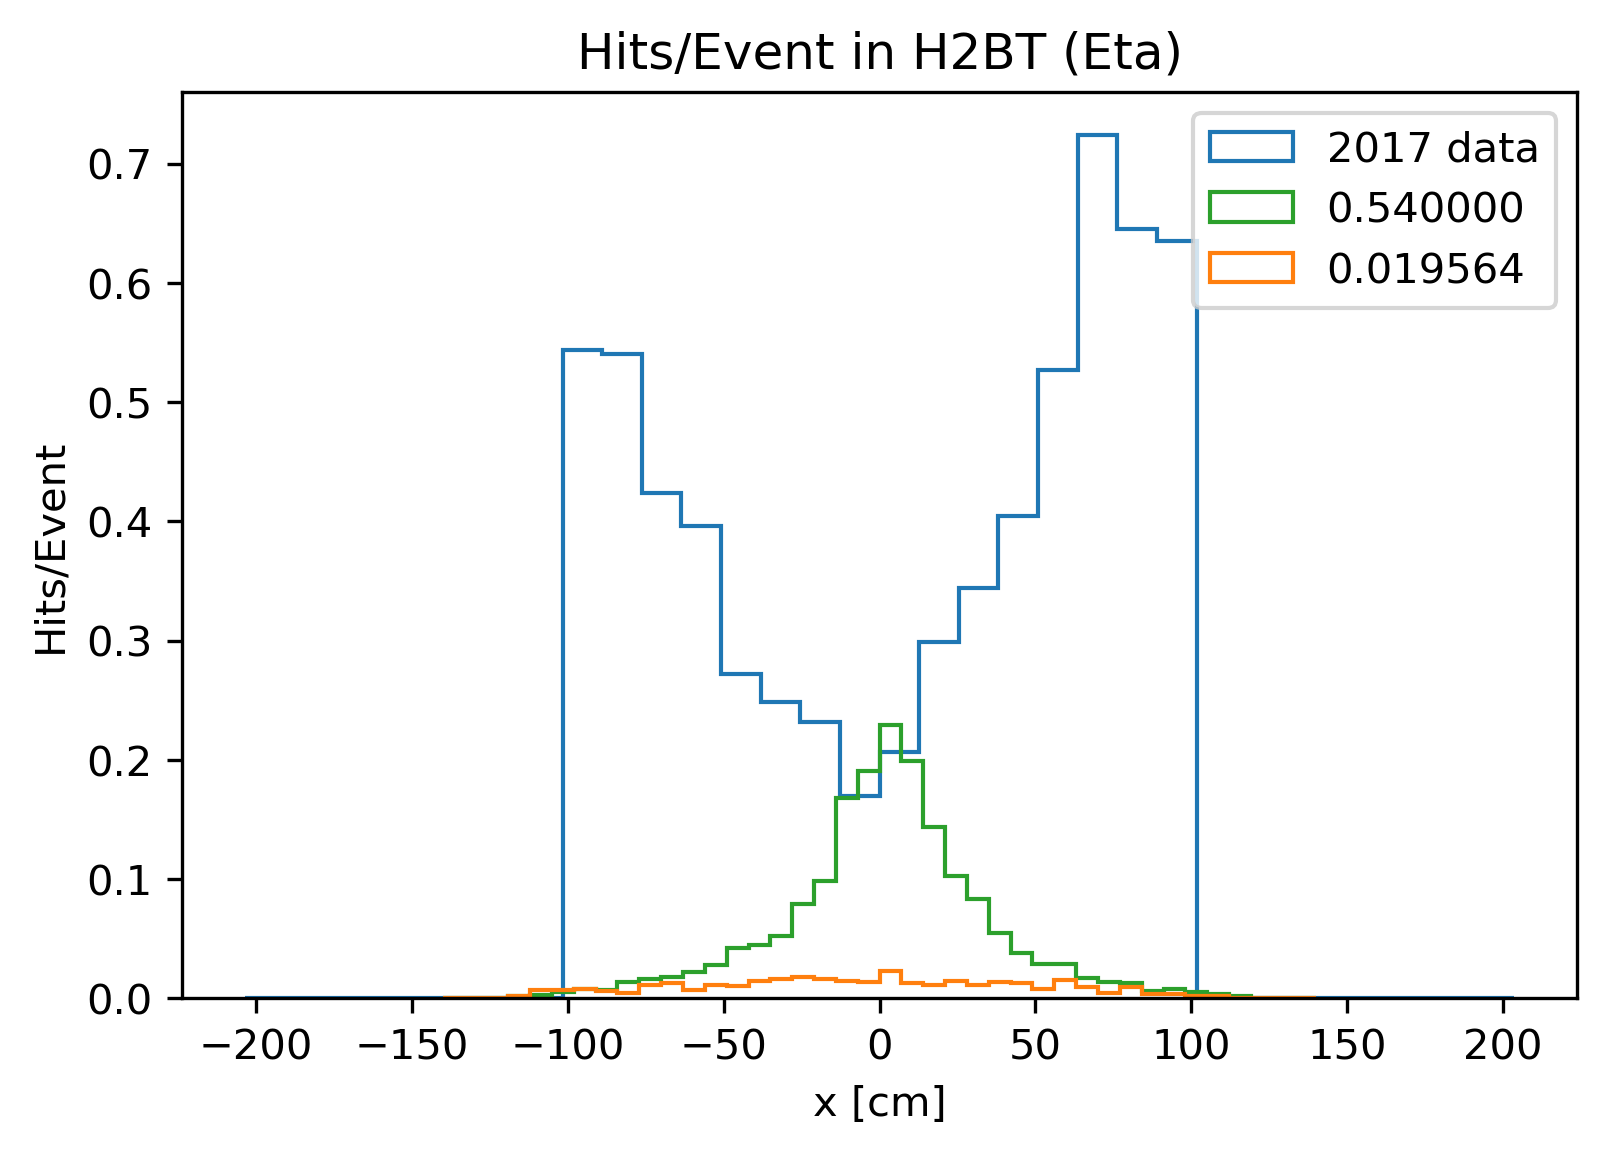

<Figure size 432x288 with 0 Axes>

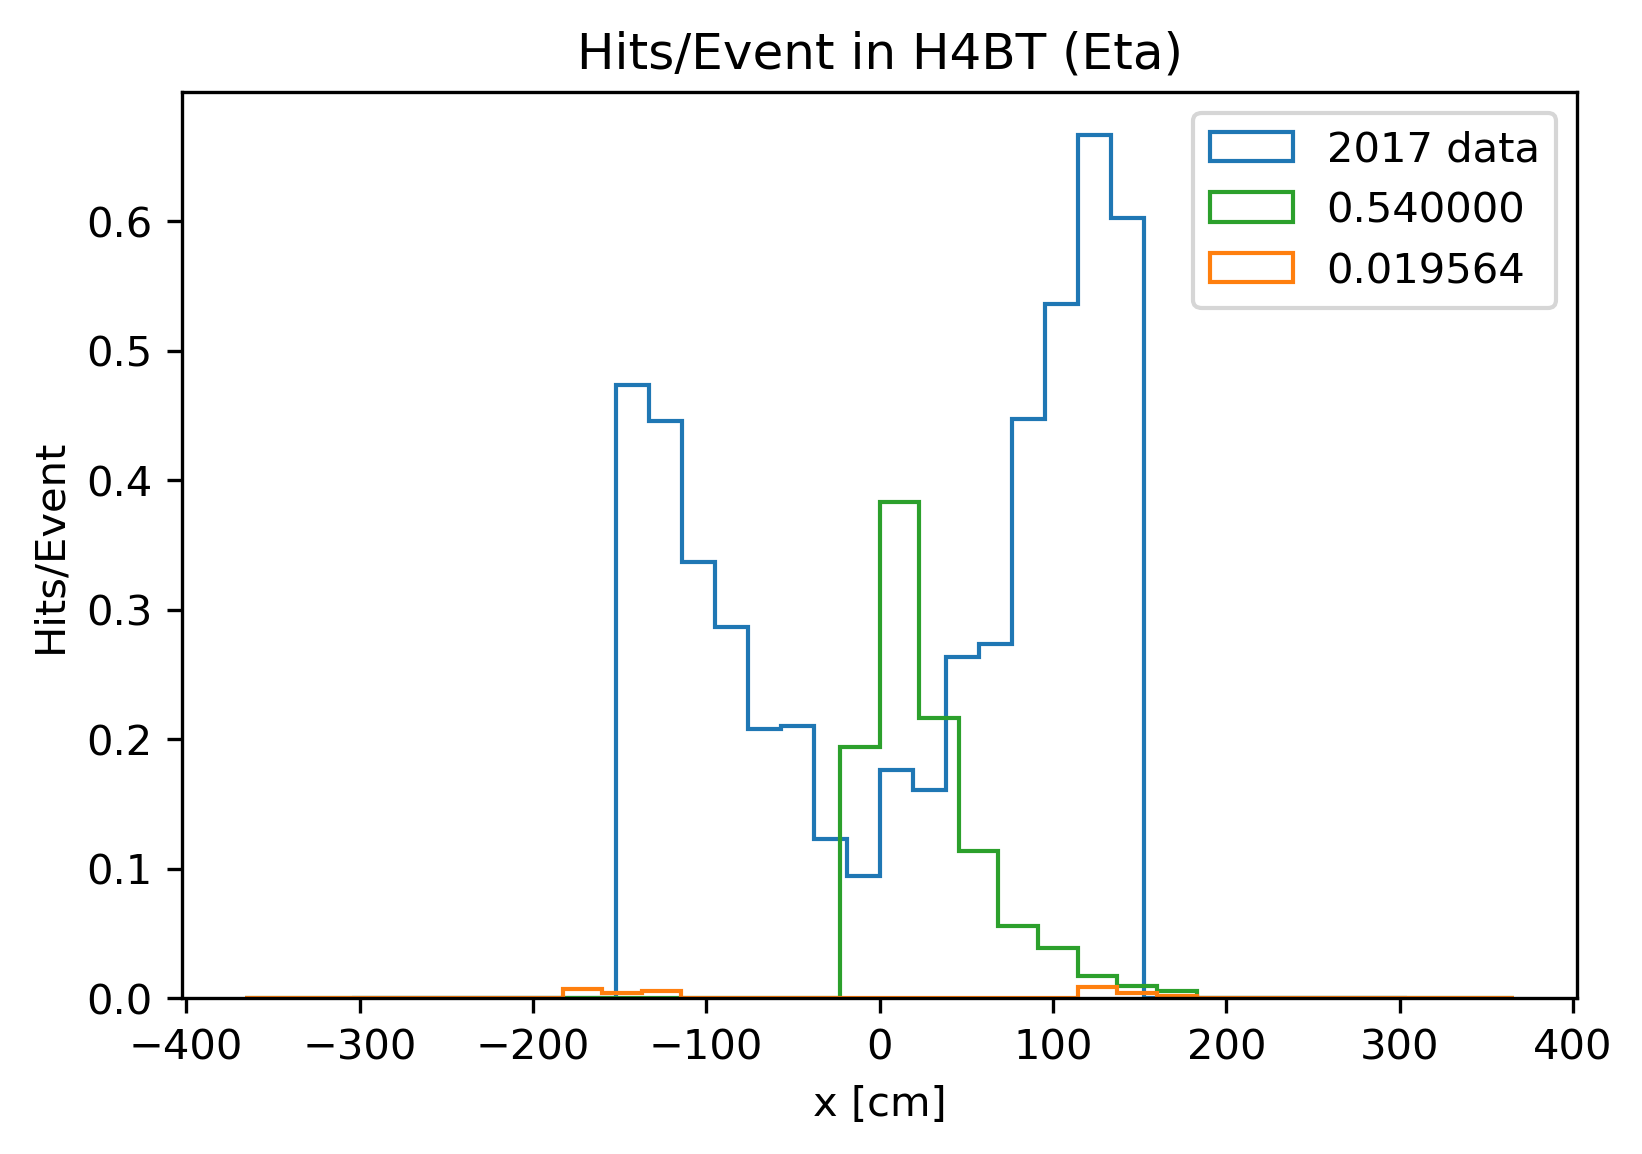

<Figure size 432x288 with 0 Axes>

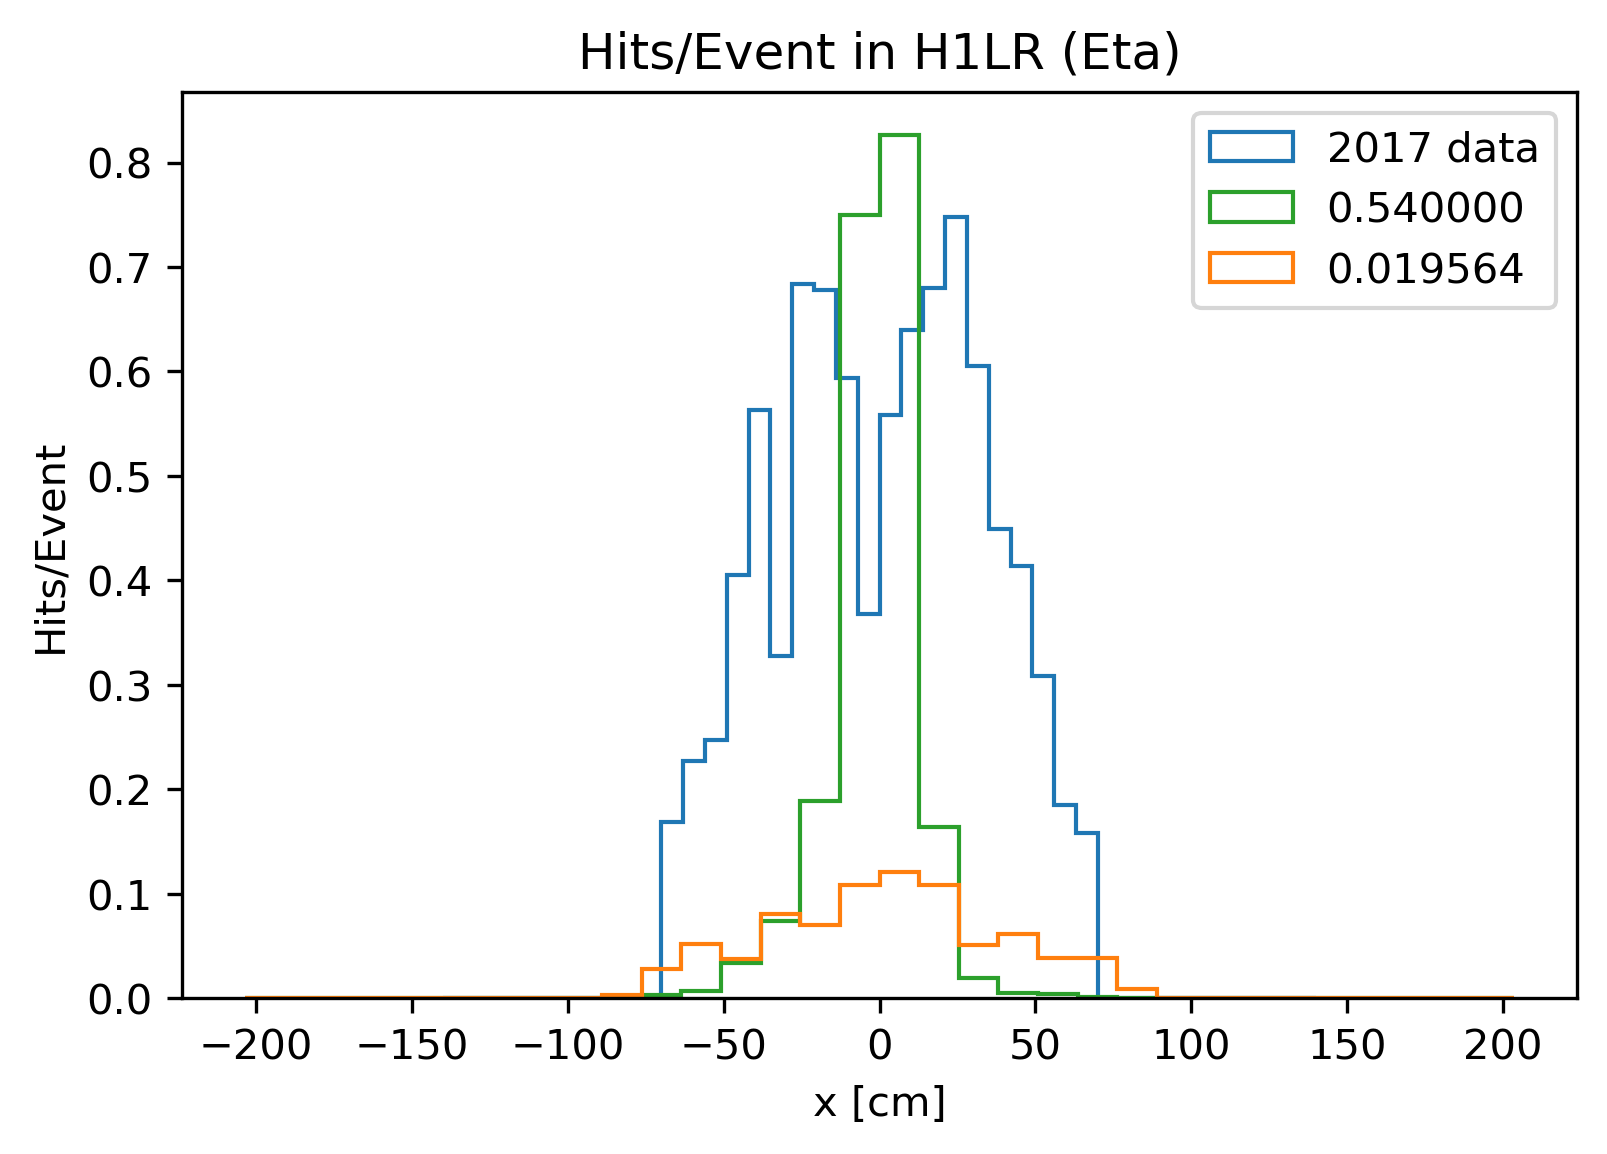

<Figure size 432x288 with 0 Axes>

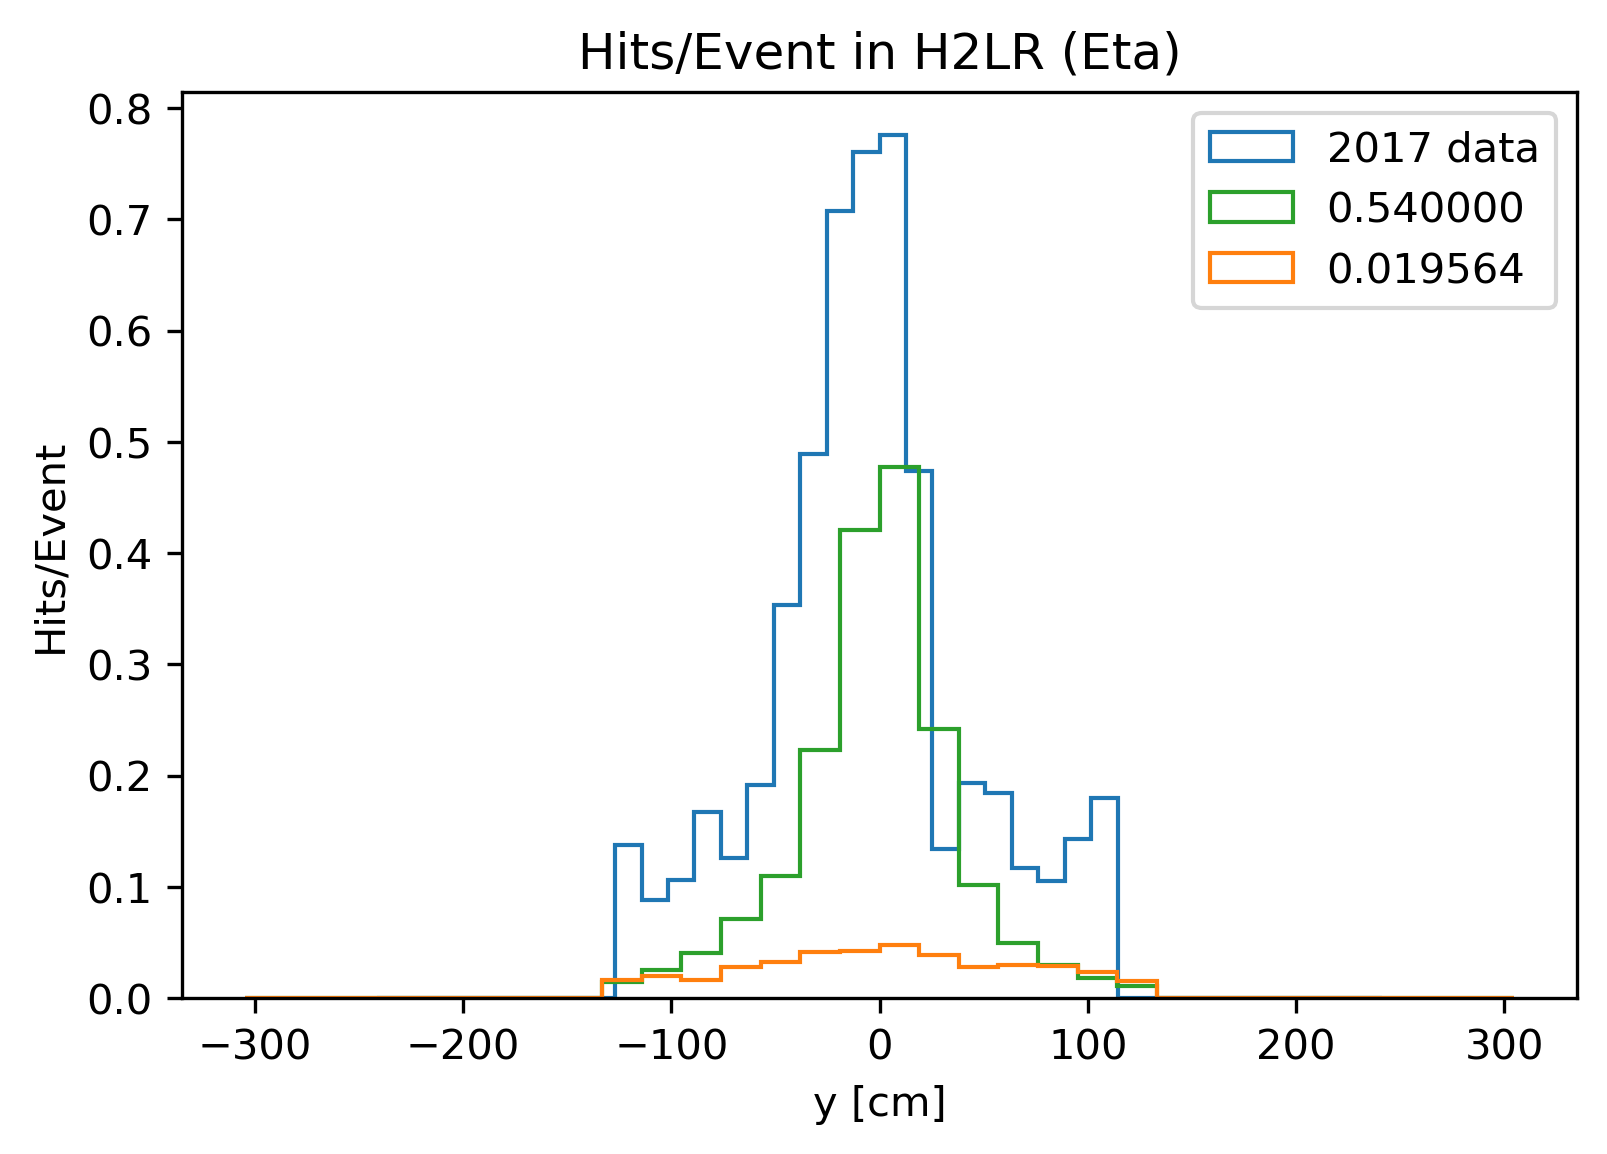

<Figure size 432x288 with 0 Axes>

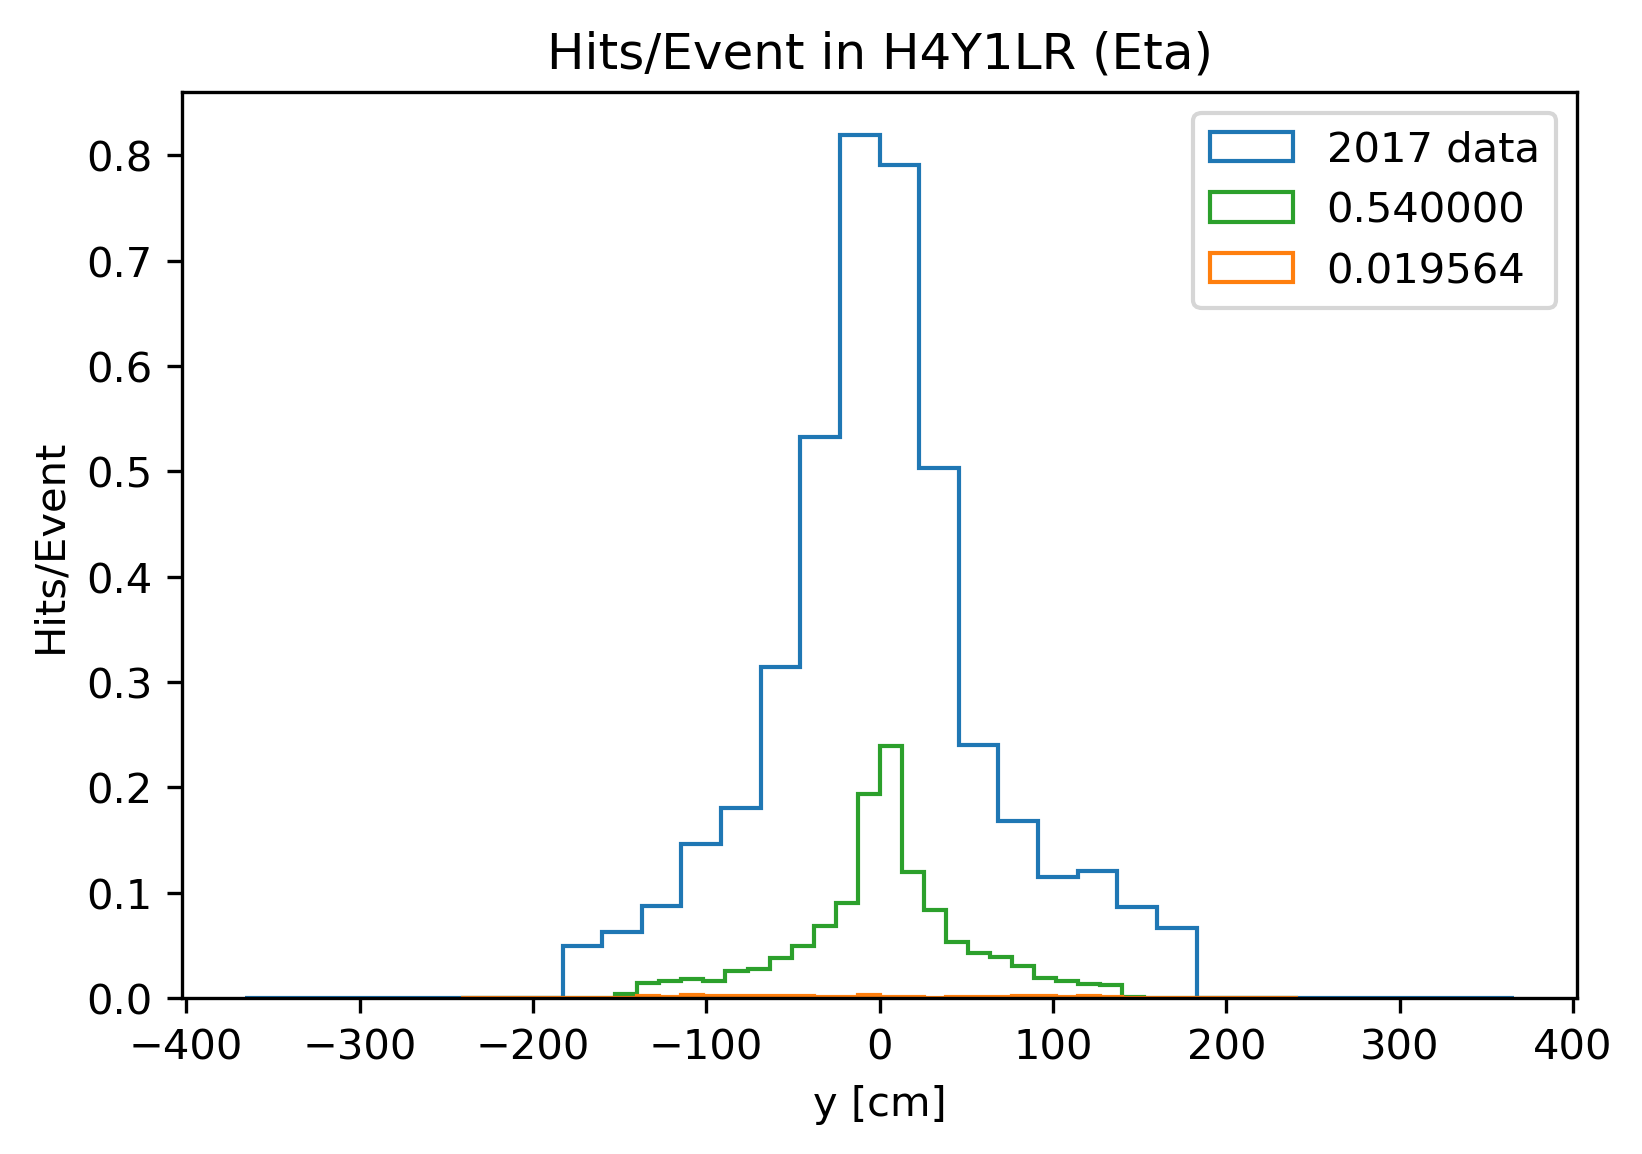

<Figure size 432x288 with 0 Axes>

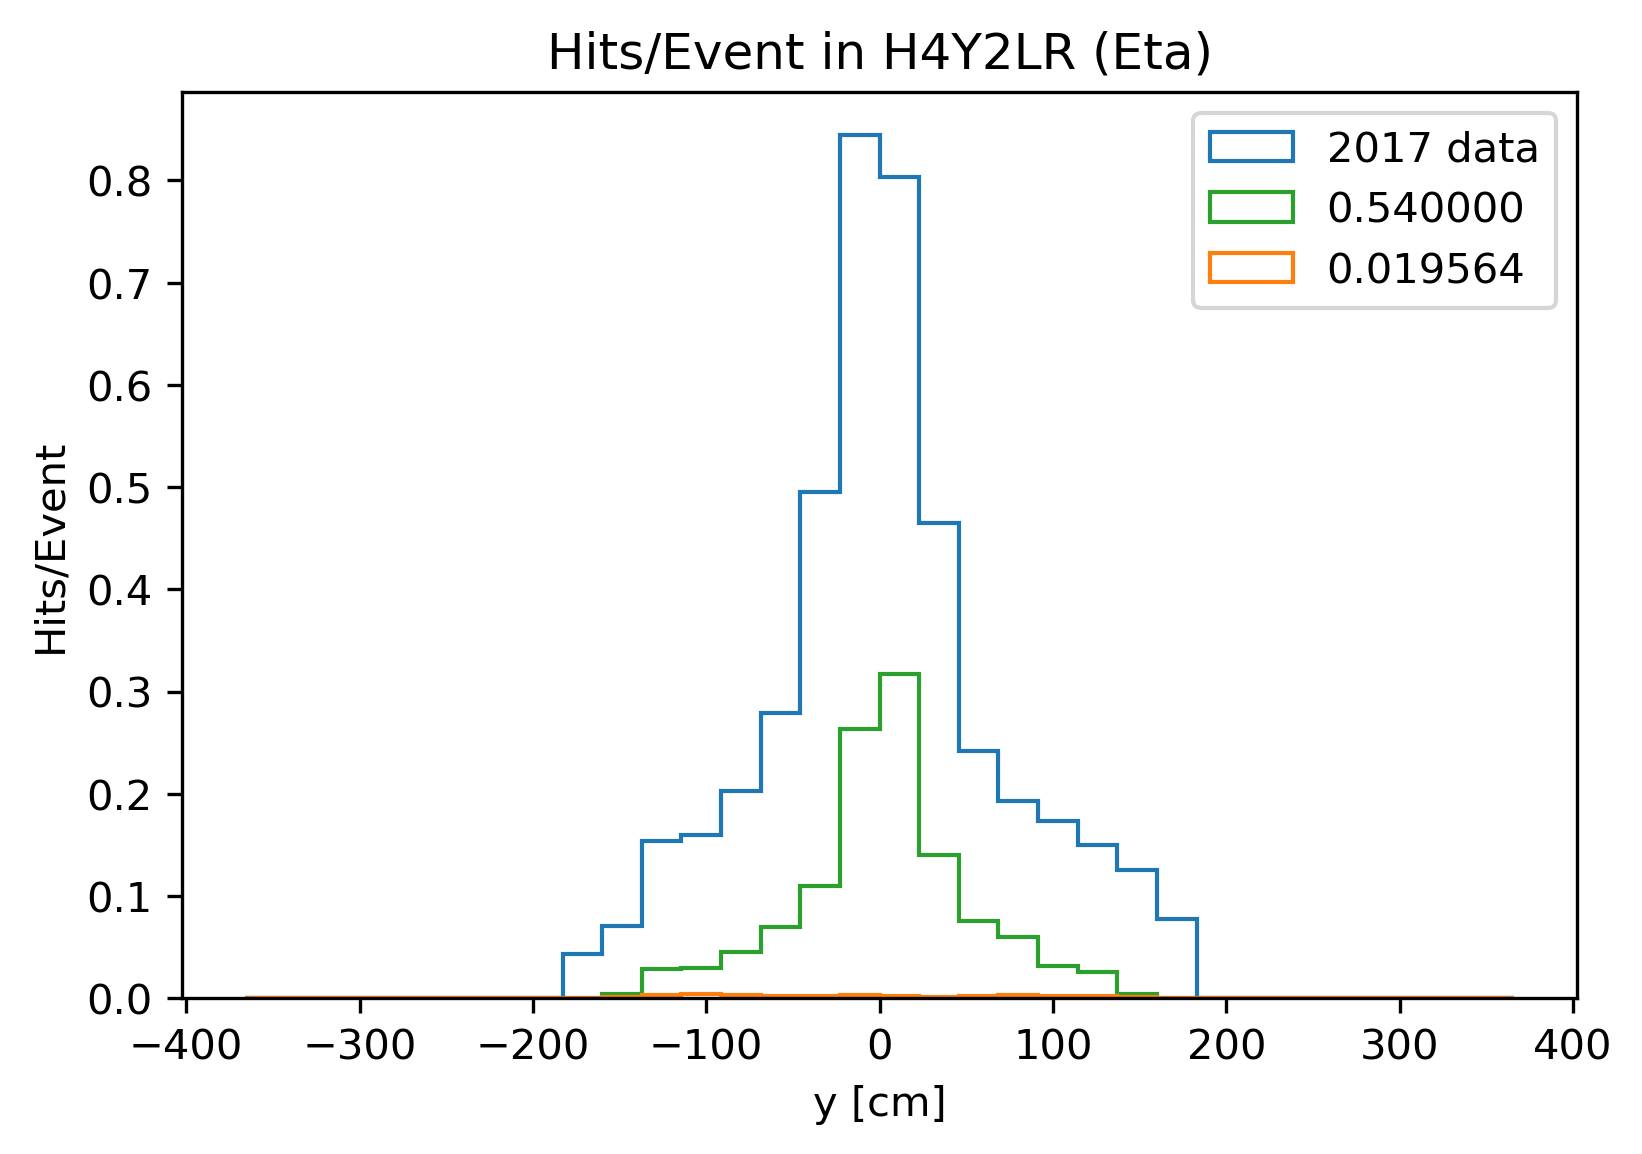

In [109]:
combine_histogram(BG,truth001,truth054,Eta001,Eta054)

<Figure size 432x288 with 0 Axes>

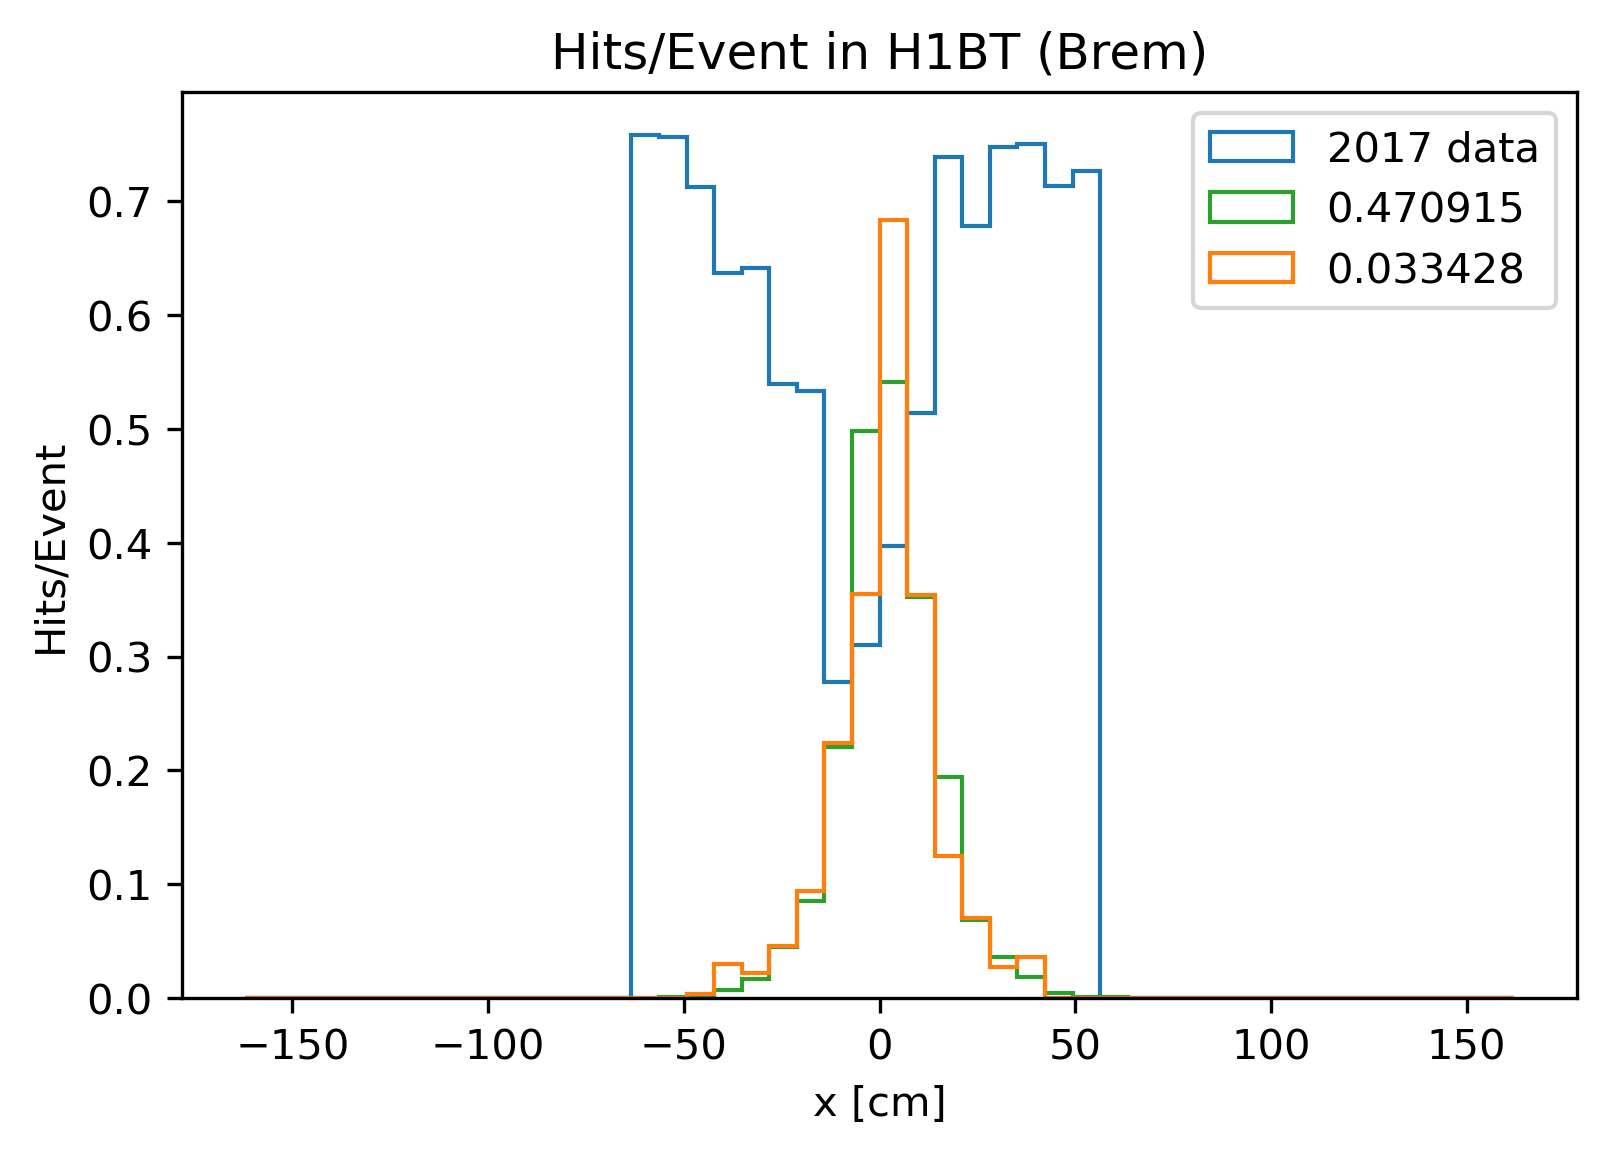

<Figure size 432x288 with 0 Axes>

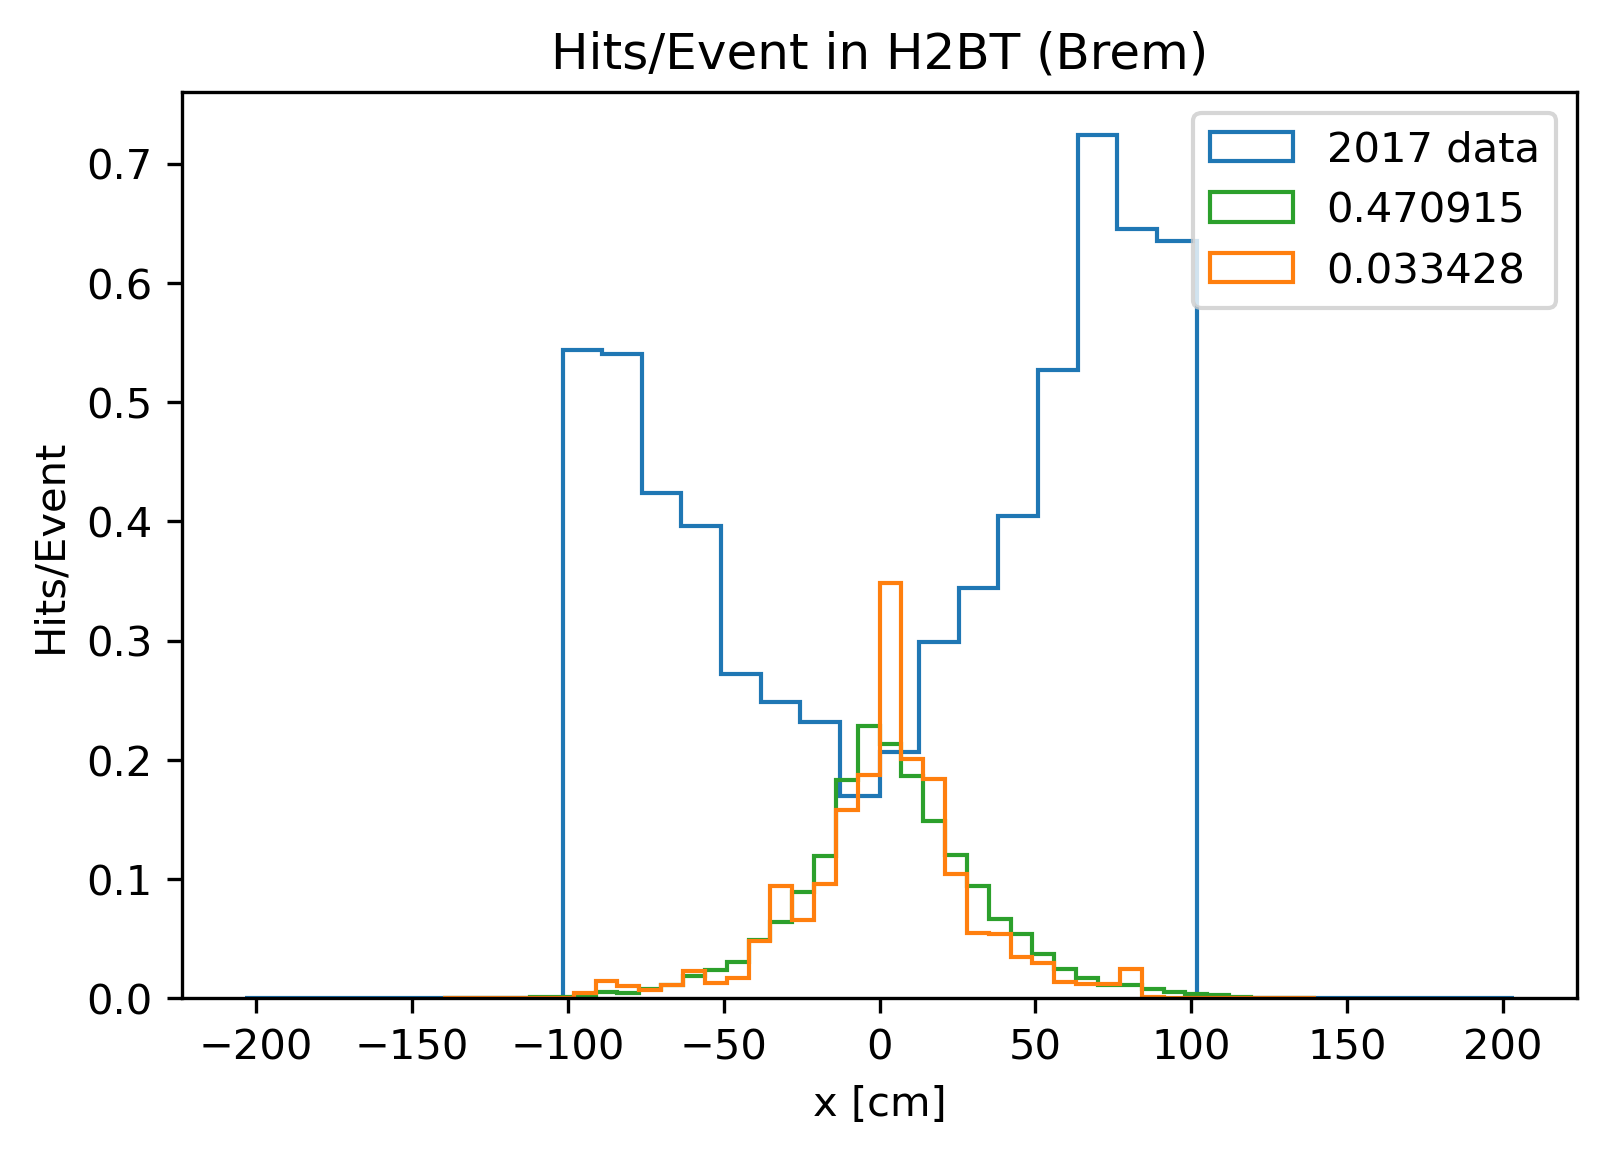

<Figure size 432x288 with 0 Axes>

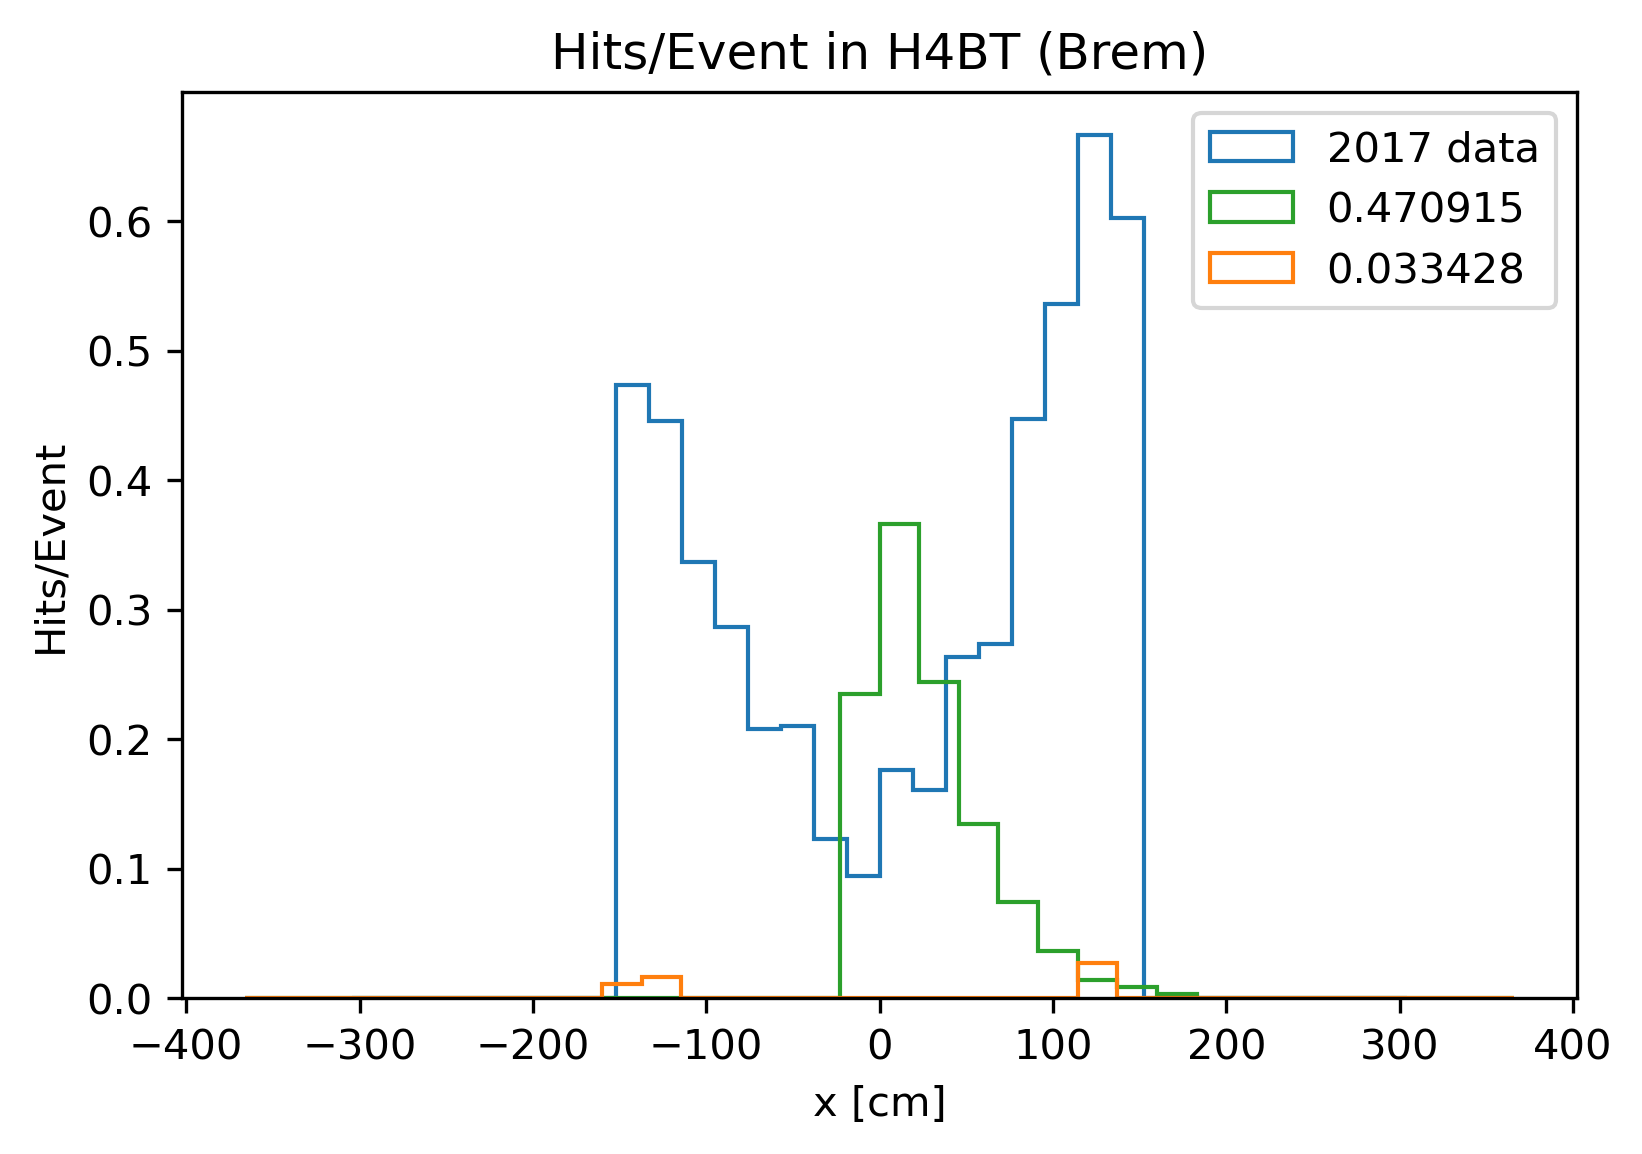

<Figure size 432x288 with 0 Axes>

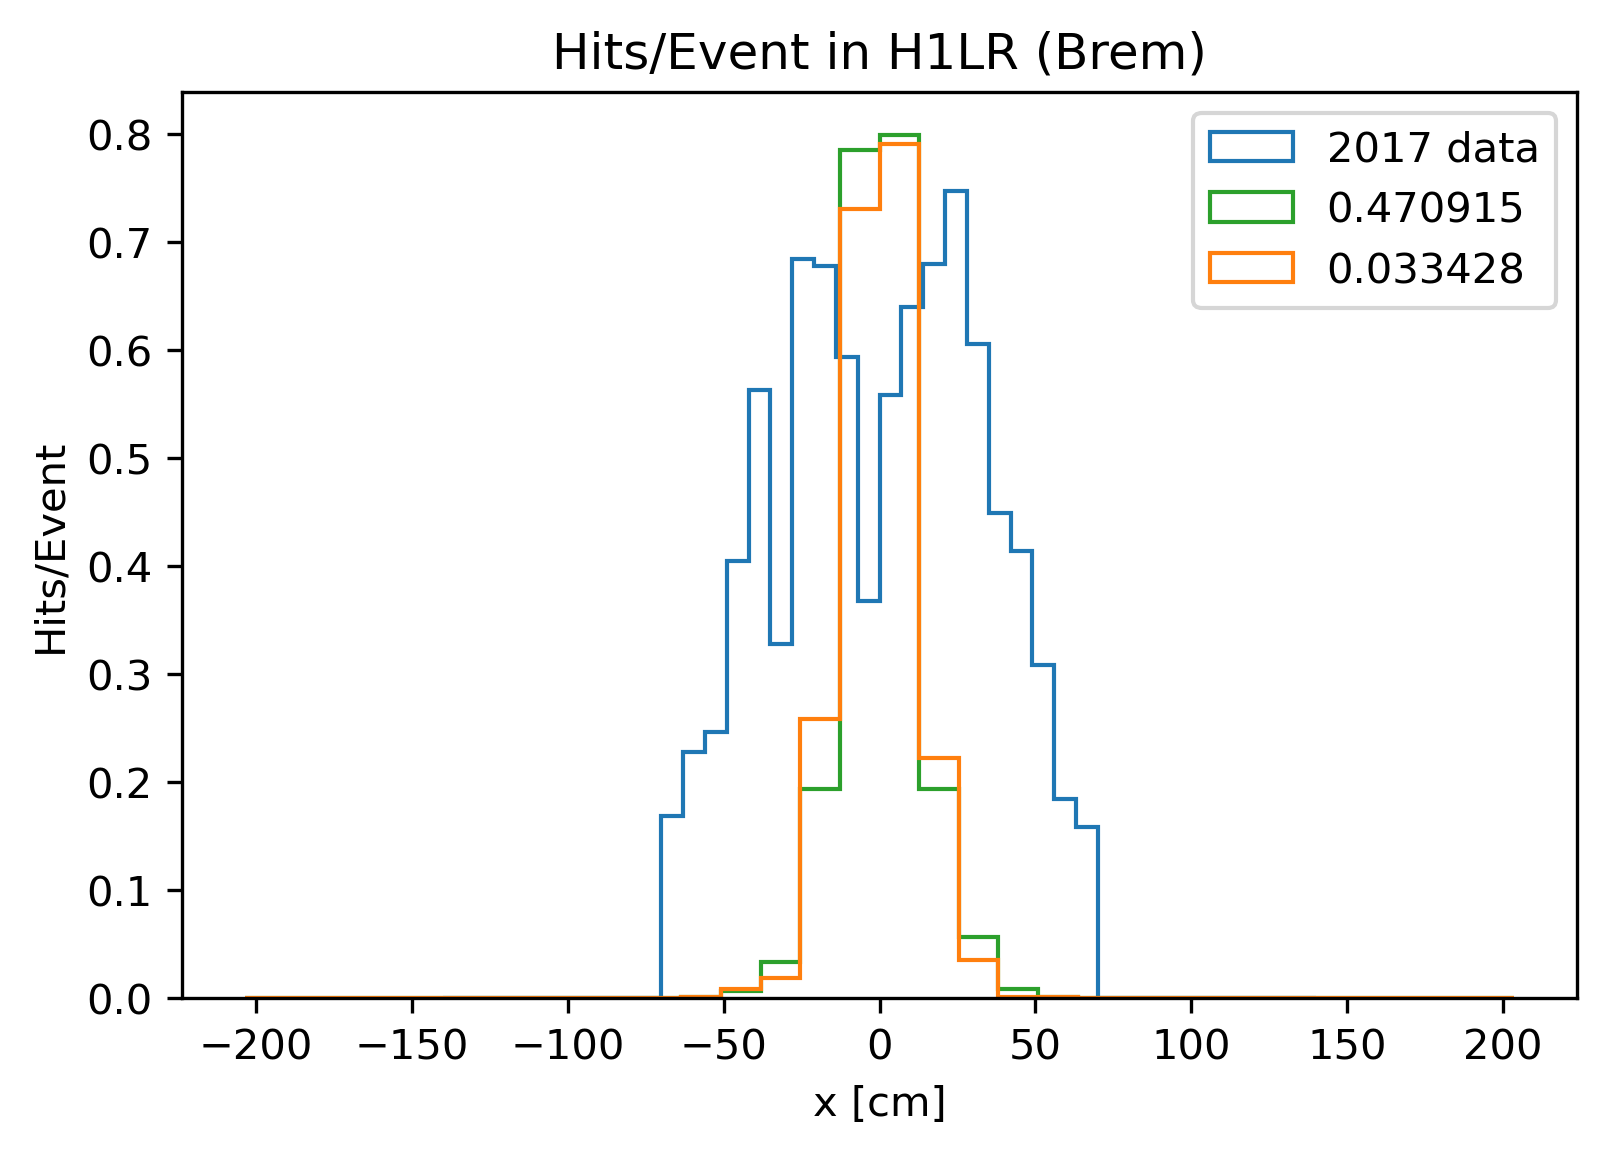

<Figure size 432x288 with 0 Axes>

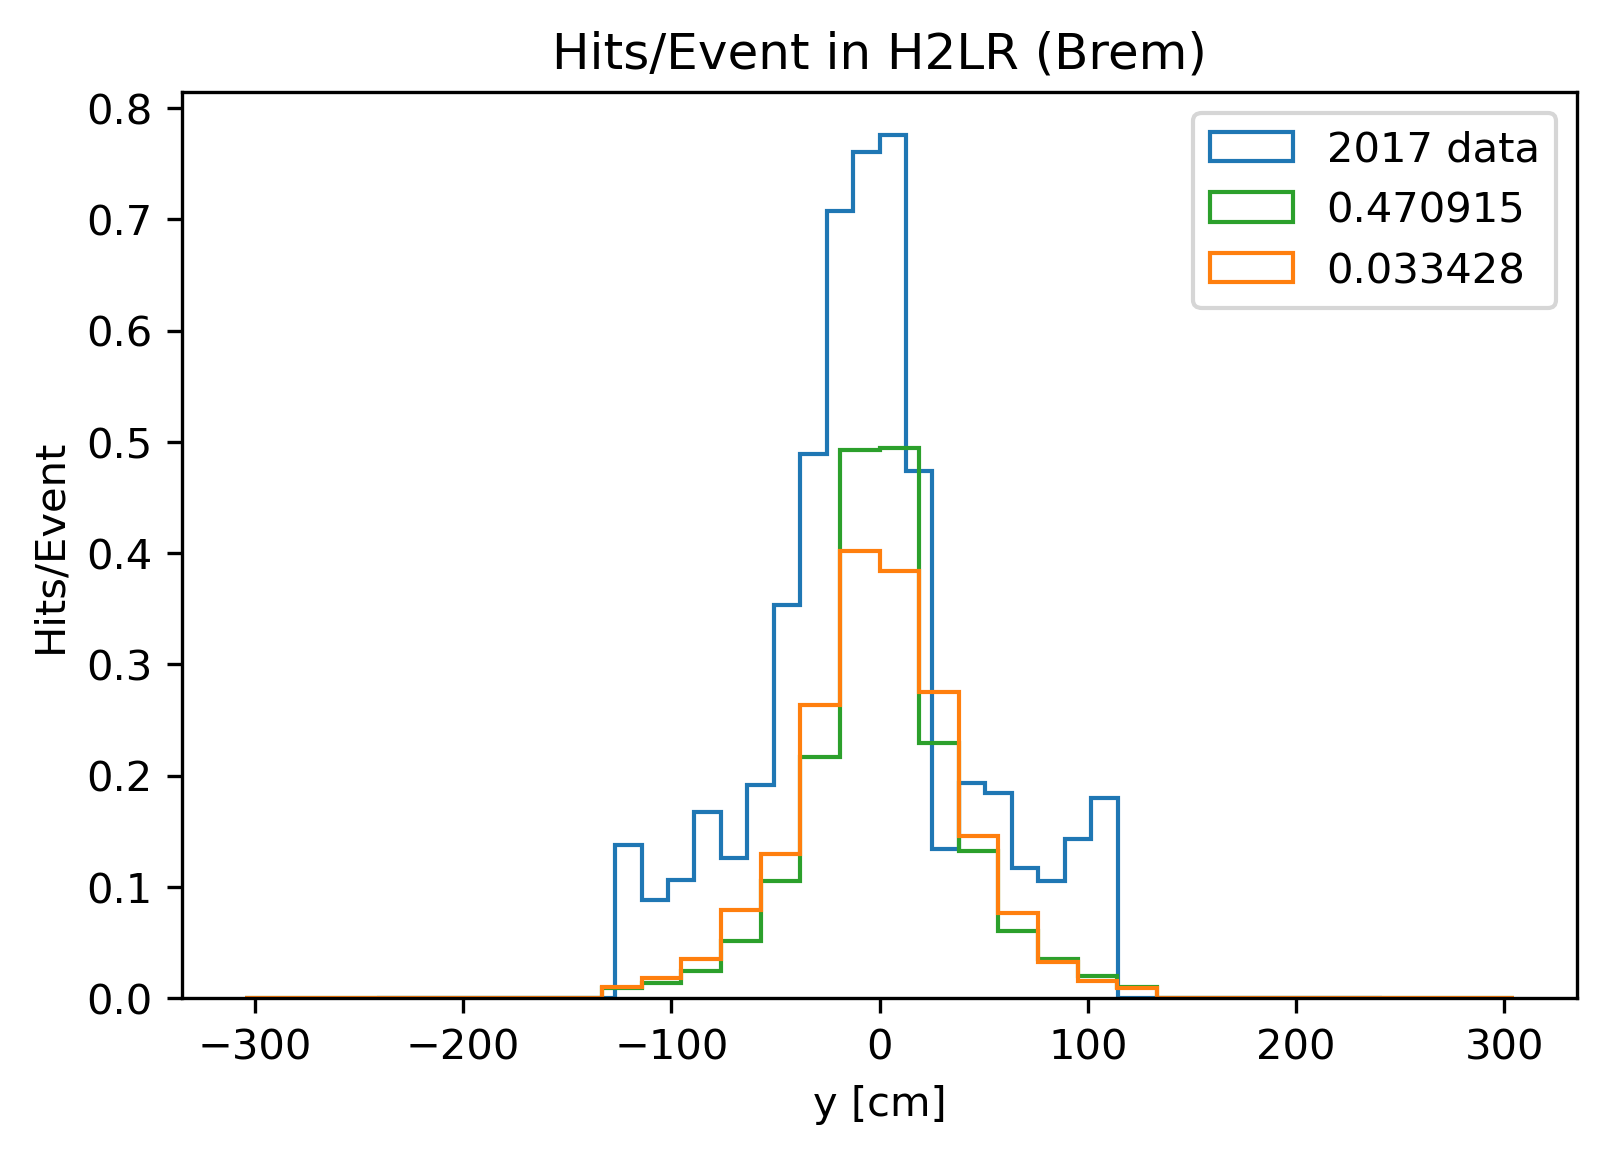

<Figure size 432x288 with 0 Axes>

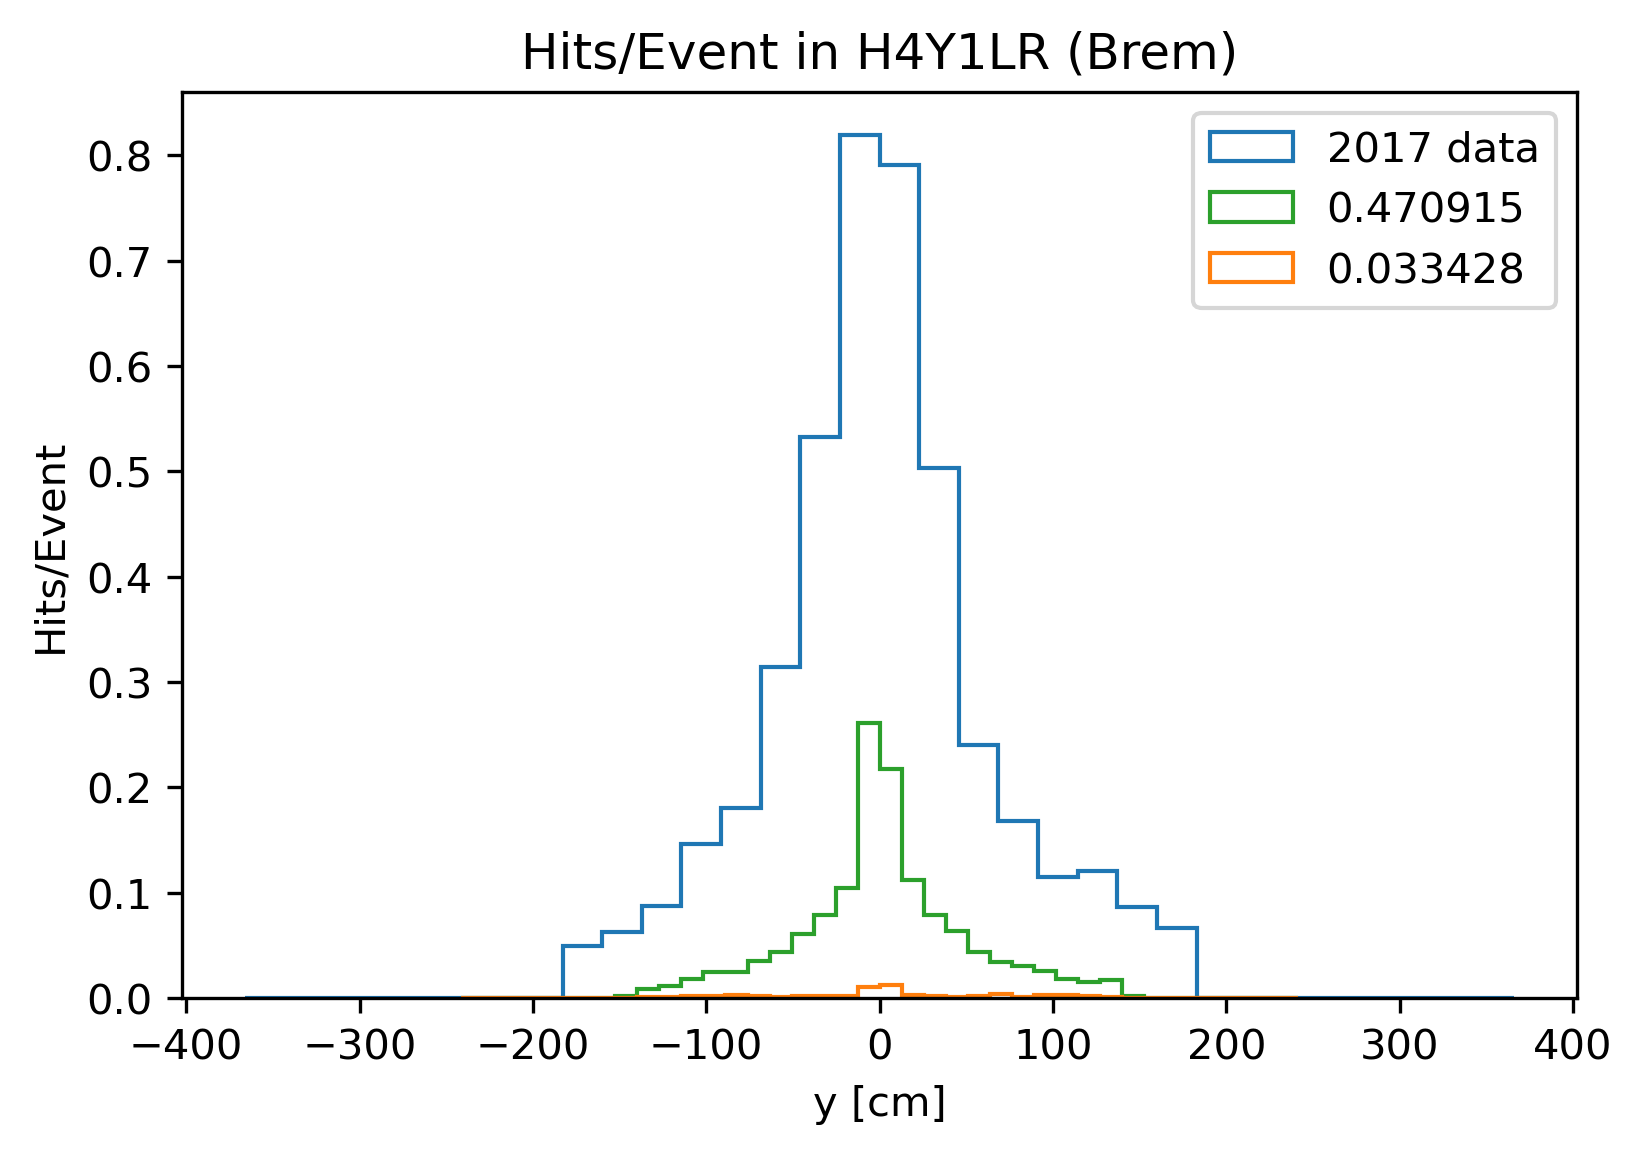

<Figure size 432x288 with 0 Axes>

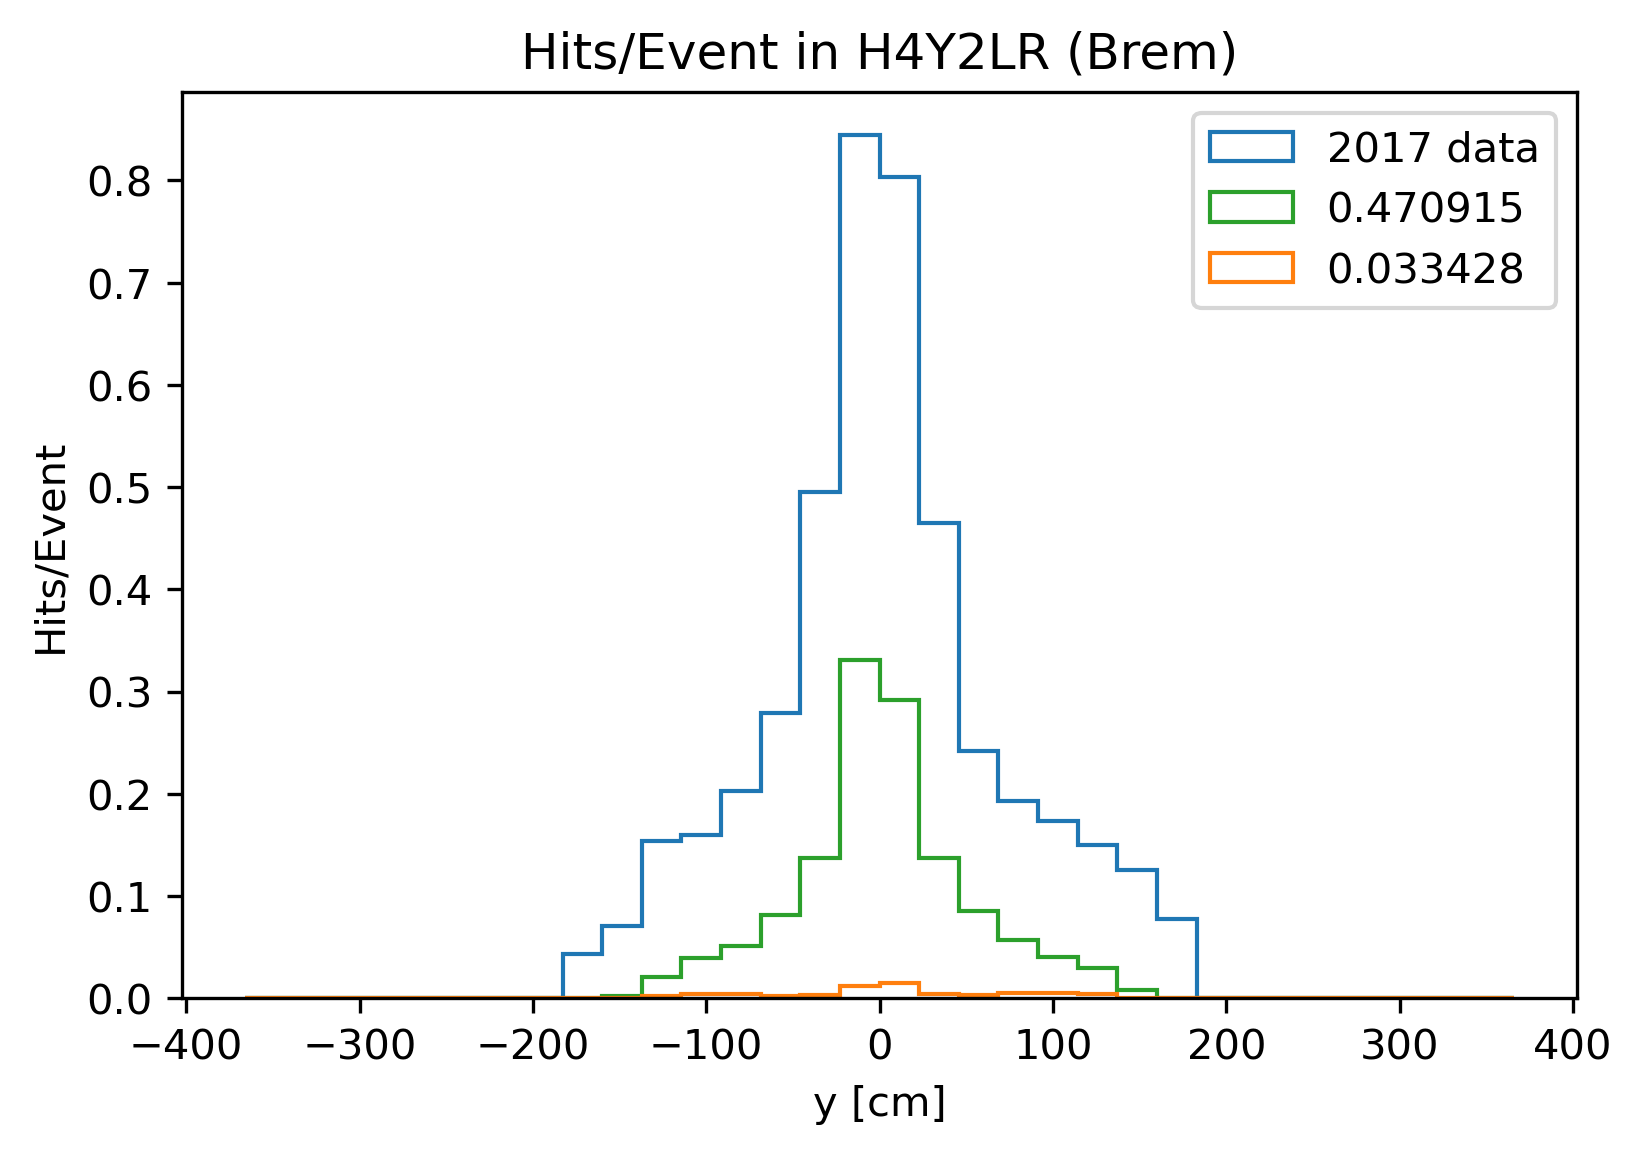

In [110]:
combine_histogram(BG,truth003,truth047,Brem003,Brem047)